In [ ]:
# !pip install opencv-python
# !pip install yattag


[notice] A new release of pip is available: 23.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
# =============================================
# DQN for SnakeGame (Full Training, 3000 episodes)
# Metrics: Sample Efficiency, Exploration, Runtime, Convergence & Stability, Policy Behavior
# Includes gameplay recording of best episode
# This notebook mirrors your Q-learning notebook 1:1 in structure and reporting.
# =============================================

# -----------------------
# 0. Imports
# -----------------------
import numpy as np
import random
import time
import datetime
import matplotlib.pyplot as plt
from collections import defaultdict, deque
import os
import warnings
warnings.filterwarnings("ignore")  # ⚙️ Keep output clean during long runs

# environment
from snake_gym.envs import snake
from snake_gym.envs.modules import UP, DOWN, LEFT, RIGHT

# DQN libs (PyTorch)
import torch
import torch.nn as nn
import torch.optim as optim

# optional: video & html
try:
    import cv2
    _HAS_CV2 = True
except Exception:
    _HAS_CV2 = False

from yattag import Doc, indent


pygame 2.6.1 (SDL 2.28.4, Python 3.10.11)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [3]:
# -----------------------
# 1. Environment Setup
# -----------------------
env = snake.SnakeGame()
n_actions = 4  # 0: UP, 1: DOWN, 2: LEFT, 3: RIGHT
dir_to_int = {UP:0, DOWN:1, LEFT:2, RIGHT:3}



In [4]:
# -----------------------
# 2. State Representation
# -----------------------
def get_state(env):
    """Simplified symbolic state: (dx, dy, direction)"""
    head_x, head_y = env.snake.get_head_position()
    apple_x, apple_y = env.apple.position
    dx = int(np.sign(apple_x - head_x))
    dy = int(np.sign(apple_y - head_y))
    direction = dir_to_int[env.snake.direction]
    return (dx, dy, direction)

def state_to_array(state_tuple):
    return np.array(state_tuple, dtype=np.float32)


In [5]:
# -----------------------
# 3. Hyperparameters
# -----------------------
episodes = 3000  # ⏳ Full training run (match Q-learning)
gamma = 0.9
epsilon_init = 1.0
epsilon_decay = 0.995
epsilon_min = 0.05
# DQN-specific
lr = 1e-3
batch_size = 64
replay_capacity = 10000
target_update_freq = 100   # update target net every 100 episodes
checkpoint_freq = 1000     # save checkpoint every 1000 episodes
log_freq = 100             # print every 100 episodes
hidden_size = 64           # Option A: 64x64 MLP (kept small to match tabular complexity)


In [6]:
# -----------------------
# 4. Multi-run Setup for Convergence
# -----------------------
seeds = [42, 123, 999]
all_rewards = []
all_epsilons = []
all_steps = []
runtime_per_seed = []

# -----------------------
# Helpers: model + replay buffer
# -----------------------
class DQNNet(nn.Module):
    def __init__(self, input_dim=3, hidden=64, output_dim=4):
        super(DQNNet, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden),
            nn.ReLU(),
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.Linear(hidden, output_dim)
        )
    def forward(self, x):
        return self.net(x)

class ReplayBuffer:
    def __init__(self, capacity=10000):
        from collections import deque
        self.buf = deque(maxlen=capacity)
    def push(self, s,a,r,s2,d):
        self.buf.append((s,a,r,s2,d))
    def sample(self, n):
        import random
        batch = random.sample(self.buf, n)
        s,a,r,s2,d = zip(*batch)
        return (np.array(s), np.array(a), np.array(r, dtype=np.float32),
                np.array(s2), np.array(d, dtype=np.float32))
    def __len__(self):
        return len(self.buf)

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cpu


In [7]:
# ==========================
# DQN Training Loop with Metrics
# ==========================

import pickle
import torch
import numpy as np
import random
import time
from collections import deque

# Assume seeds, episodes, epsilon_init, epsilon_decay, epsilon_min, etc. are defined
# Also assume env, DQNNet, ReplayBuffer, device, and other DQN settings are defined

all_rewards_dqn = []
all_epsilons_dqn = []
all_steps_dqn = []
runtime_per_seed_dqn = []

for seed in seeds:
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

    # Initialize policy and target networks
    policy_net = DQNNet(input_dim=3, hidden=hidden_size, output_dim=n_actions).to(device)
    target_net = DQNNet(input_dim=3, hidden=hidden_size, output_dim=n_actions).to(device)
    target_net.load_state_dict(policy_net.state_dict())
    target_net.eval()

    optimizer = torch.optim.Adam(policy_net.parameters(), lr=lr)
    memory = ReplayBuffer(capacity=replay_capacity)

    rewards_per_episode = []
    moving_avg_rewards = deque(maxlen=10)
    epsilons = []
    steps_per_episode = []

    epsilon = epsilon_init
    start_time = time.time()

    for episode in range(episodes):
        env.reset()
        state = get_state(env)
        state_arr = state_to_array(state)
        done = False
        total_reward = 0.0
        steps = 0

        while not done:
            if random.random() < epsilon:
                action = random.randrange(n_actions)
            else:
                with torch.no_grad():
                    st = torch.tensor(state_arr, dtype=torch.float32, device=device).unsqueeze(0)
                    qvals = policy_net(st)
                    action = int(torch.argmax(qvals).item())

            frame, reward, done, _ = env.step(action)
            next_state = get_state(env)
            next_state_arr = state_to_array(next_state)

            memory.push(state_arr, action, reward, next_state_arr, done)
            state_arr = next_state_arr
            total_reward += reward
            steps += 1

            # DQN update
            if len(memory) >= batch_size:
                s_batch, a_batch, r_batch, s2_batch, d_batch = memory.sample(batch_size)
                s_t = torch.tensor(s_batch, dtype=torch.float32, device=device)
                a_t = torch.tensor(a_batch, dtype=torch.long, device=device)
                r_t = torch.tensor(r_batch, dtype=torch.float32, device=device)
                s2_t = torch.tensor(s2_batch, dtype=torch.float32, device=device)
                d_t = torch.tensor(d_batch, dtype=torch.float32, device=device)

                q_values = policy_net(s_t).gather(1, a_t.unsqueeze(1)).squeeze(1)
                with torch.no_grad():
                    next_q = target_net(s2_t).max(1)[0]
                    target_q = r_t + gamma * next_q * (1 - d_t)
                loss = torch.nn.MSELoss()(q_values, target_q)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        # End episode bookkeeping
        epsilon = max(epsilon_min, epsilon * epsilon_decay)
        rewards_per_episode.append(total_reward)
        moving_avg_rewards.append(total_reward)
        epsilons.append(epsilon)
        steps_per_episode.append(steps)

        # Print progress
        if (episode + 1) % log_freq == 0:
            avg_reward = np.mean(moving_avg_rewards) if len(moving_avg_rewards) > 0 else 0.0
            print(f"Seed {seed} | Episode {episode+1}/{episodes} | Avg Reward (last {len(moving_avg_rewards)}): {avg_reward:.2f} | ε={epsilon:.3f}")

        # Checkpoint and save metrics
        if (episode + 1) % checkpoint_freq == 0:
            torch.save(policy_net.state_dict(), f"checkpoint_dqn_seed_{seed}_ep_{episode+1}.pth")
            with open(f"rewards_dqn_seed_{seed}_ep_{episode+1}.pkl", "wb") as f:
                pickle.dump(rewards_per_episode, f)
            with open(f"epsilons_dqn_seed_{seed}_ep_{episode+1}.pkl", "wb") as f:
                pickle.dump(epsilons, f)
            with open(f"steps_dqn_seed_{seed}_ep_{episode+1}.pkl", "wb") as f:
                pickle.dump(steps_per_episode, f)
            print(f"💾 Checkpoint & metrics saved at episode {episode+1}")

        # Update target network periodically
        if (episode + 1) % target_update_freq == 0:
            target_net.load_state_dict(policy_net.state_dict())

    # End of seed
    end_time = time.time()
    avg_time_per_episode = (end_time - start_time) / episodes
    runtime_per_seed_dqn.append(avg_time_per_episode)

    all_rewards.append(rewards_per_episode)
    all_epsilons.append(epsilons)
    all_steps.append(steps_per_episode)

    # Save final model and metrics
    torch.save(policy_net.state_dict(), f"dqn_model_seed_{seed}.pth")
    with open(f"rewards_dqn_seed_{seed}.pkl", "wb") as f:
        pickle.dump(rewards_per_episode, f)
    with open(f"epsilons_dqn_seed_{seed}.pkl", "wb") as f:
        pickle.dump(epsilons, f)
    with open(f"steps_dqn_seed_{seed}.pkl", "wb") as f:
        pickle.dump(steps_per_episode, f)
    print(f"✅ DQN model & metrics saved for seed {seed}")


Seed 42 | Episode 100/3000 | Avg Reward (last 10): 7.93 | ε=0.606
Seed 42 | Episode 200/3000 | Avg Reward (last 10): 15.20 | ε=0.367
Seed 42 | Episode 300/3000 | Avg Reward (last 10): 23.72 | ε=0.222
Seed 42 | Episode 400/3000 | Avg Reward (last 10): 49.87 | ε=0.135
Seed 42 | Episode 500/3000 | Avg Reward (last 10): 43.36 | ε=0.082
Seed 42 | Episode 600/3000 | Avg Reward (last 10): 64.92 | ε=0.050
Seed 42 | Episode 700/3000 | Avg Reward (last 10): 74.86 | ε=0.050
Seed 42 | Episode 800/3000 | Avg Reward (last 10): 89.14 | ε=0.050
Seed 42 | Episode 900/3000 | Avg Reward (last 10): 79.96 | ε=0.050
Seed 42 | Episode 1000/3000 | Avg Reward (last 10): 73.87 | ε=0.050
💾 Checkpoint & metrics saved at episode 1000
Seed 42 | Episode 1100/3000 | Avg Reward (last 10): 59.41 | ε=0.050
Seed 42 | Episode 1200/3000 | Avg Reward (last 10): 93.08 | ε=0.050
Seed 42 | Episode 1300/3000 | Avg Reward (last 10): 52.03 | ε=0.050
Seed 42 | Episode 1400/3000 | Avg Reward (last 10): 71.90 | ε=0.050
Seed 42 | Epi

Seed 42 | Episodes to 80% max reward: None
Seed 123 | Episodes to 80% max reward: None
Seed 999 | Episodes to 80% max reward: None


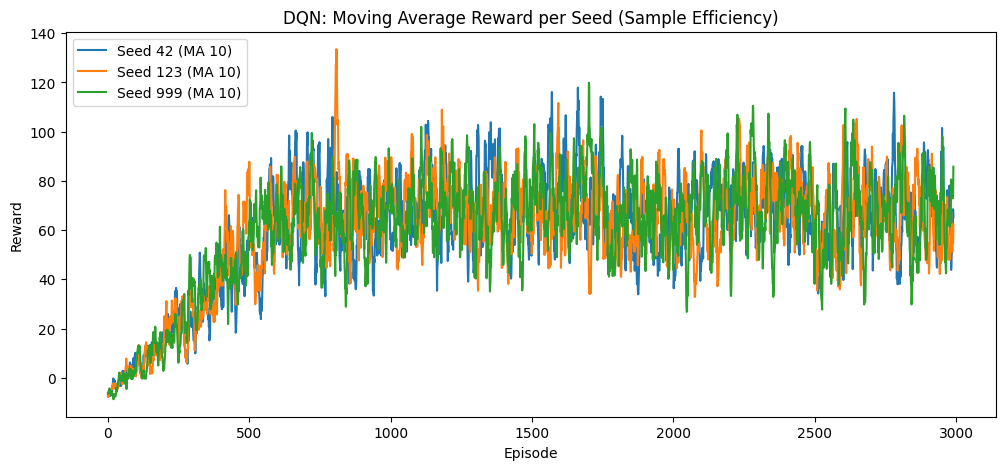

In [8]:
# -----------------------
# 6. Sample Efficiency
# -----------------------
plt.figure(figsize=(12,5))
ma_window = 10
for i, rewards in enumerate(all_rewards):
    ma = np.convolve(rewards, np.ones(ma_window)/ma_window, mode='valid') if len(rewards)>=ma_window else np.array([])
    max_reward = max(rewards) if len(rewards)>0 else 0.0
    target = 0.8 * max_reward
    episodes_to_80 = next((idx for idx, r in enumerate(ma) if r >= target), None) if len(ma)>0 else None
    print(f"Seed {seeds[i]} | Episodes to 80% max reward: {episodes_to_80}")
    if len(ma)>0:
        plt.plot(ma, label=f"Seed {seeds[i]} (MA 10)")
plt.title("DQN: Moving Average Reward per Seed (Sample Efficiency)")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.legend()
plt.show()


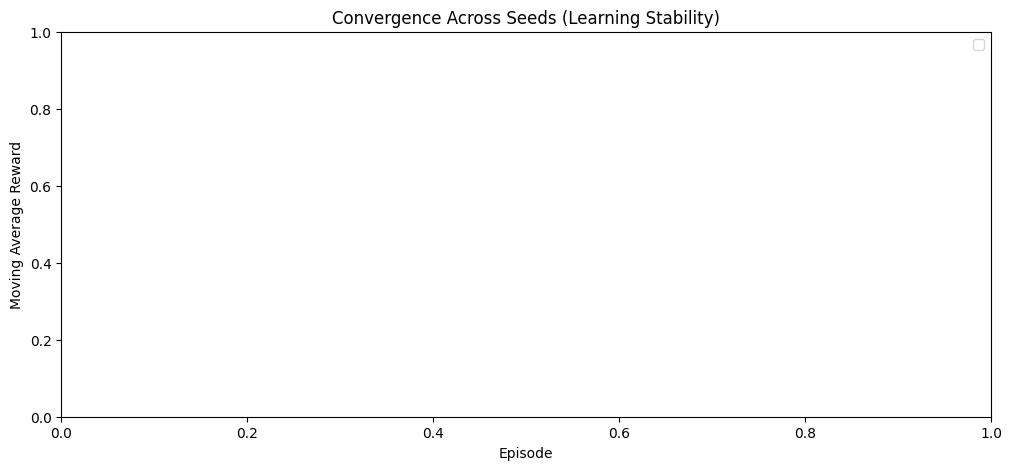

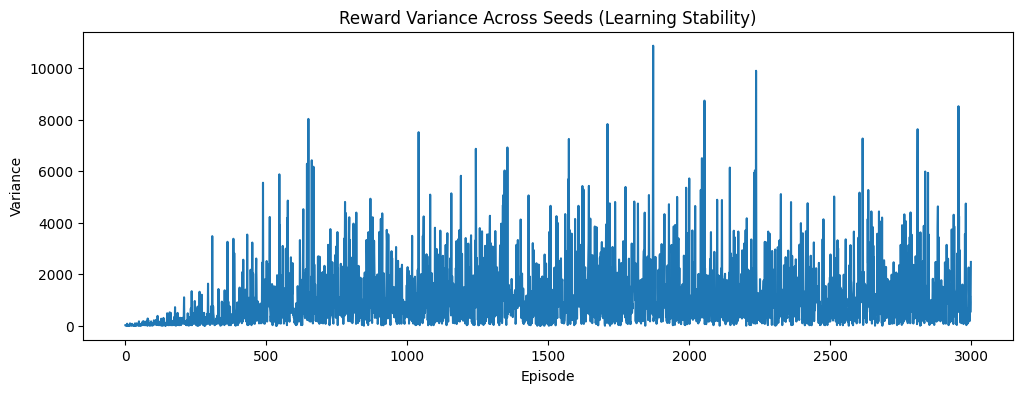

In [9]:
# -----------------------
# 7. Convergence & Stability Visualization
# -----------------------
plt.figure(figsize=(12,5))
for i, rewards in enumerate(all_rewards_dqn):
    ma = np.convolve(rewards, np.ones(ma_window)/ma_window, mode='valid') if len(rewards)>=ma_window else np.array([])
    if len(ma)>0:
        plt.plot(ma, label=f"Seed {seeds[i]}")
plt.title("Convergence Across Seeds (Learning Stability)")
plt.xlabel("Episode")
plt.ylabel("Moving Average Reward")
plt.legend()
plt.show()

# Variance across seeds
max_len = max(len(r) for r in all_rewards) if len(all_rewards)>0 else 0
padded_rewards = [np.pad(r, (0, max_len - len(r)), 'edge') for r in all_rewards] if max_len>0 else []
reward_variance_across_seeds = np.var(padded_rewards, axis=0) if len(padded_rewards)>0 else np.array([])
plt.figure(figsize=(12,4))
if reward_variance_across_seeds.size>0:
    plt.plot(reward_variance_across_seeds)
plt.title("Reward Variance Across Seeds (Learning Stability)")
plt.xlabel("Episode")
plt.ylabel("Variance")
plt.show()


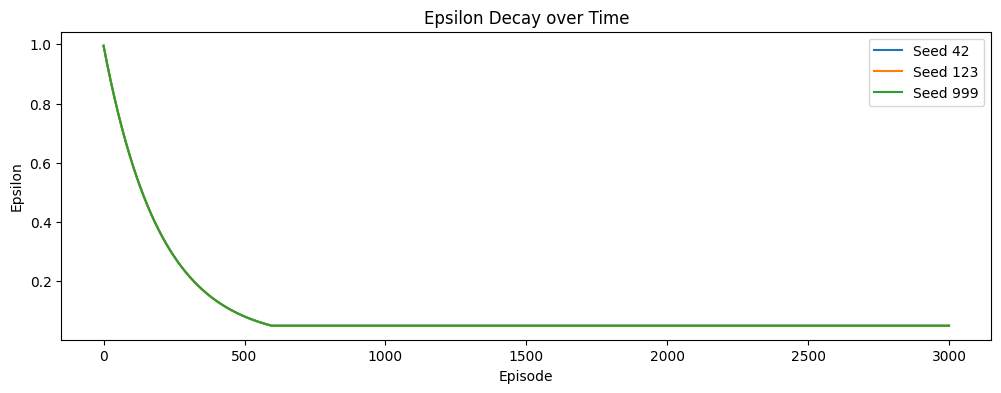

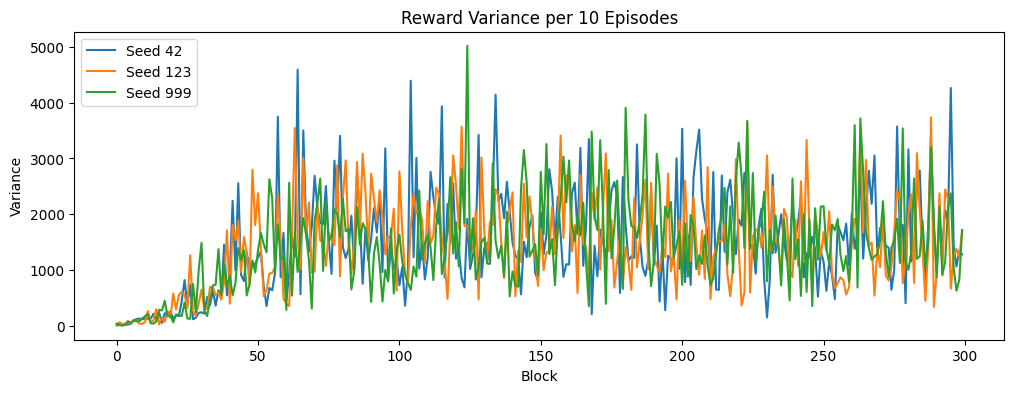

In [10]:
# -----------------------
# 8. Exploration Stability
# -----------------------
# Epsilon decay
plt.figure(figsize=(12,4))
for i, eps in enumerate(all_epsilons):
    plt.plot(eps, label=f"Seed {seeds[i]}")
plt.title("Epsilon Decay over Time")
plt.xlabel("Episode")
plt.ylabel("Epsilon")
plt.legend()
plt.show()

# Reward variance per 10-episode block
block_size = 10
plt.figure(figsize=(12,4))
for i, rewards in enumerate(all_rewards):
    variance = [np.var(rewards[j:j+block_size]) for j in range(0, len(rewards), block_size)]
    plt.plot(variance, label=f"Seed {seeds[i]}")
plt.title("Reward Variance per 10 Episodes")
plt.xlabel("Block")
plt.ylabel("Variance")
plt.legend()
plt.show()


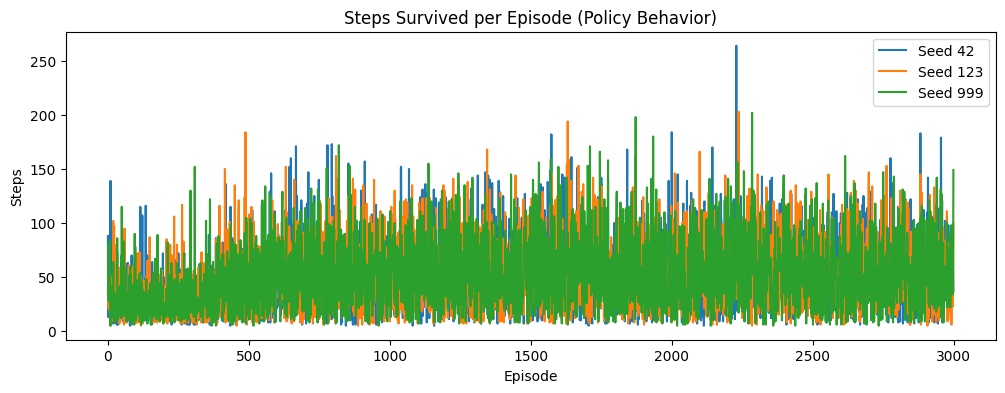

In [11]:
# -----------------------
# 9. Policy Behavior (Steps Survived)
# -----------------------
plt.figure(figsize=(12,4))
for i, steps in enumerate(all_steps):
    plt.plot(steps, label=f"Seed {seeds[i]}")
plt.title("Steps Survived per Episode (Policy Behavior)")
plt.xlabel("Episode")
plt.ylabel("Steps")
plt.legend()
plt.show()


ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (3,) and arg 1 with shape (0,).

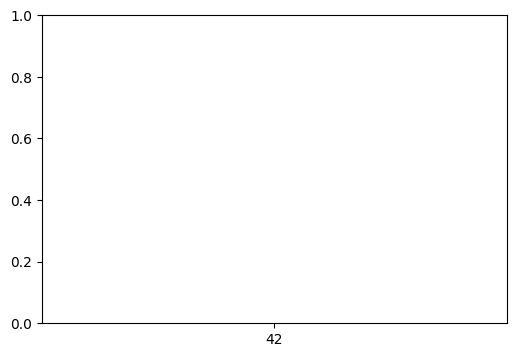

In [12]:
# -----------------------
# 10. Runtime / Computational Efficiency
# -----------------------
plt.figure(figsize=(6,4))
plt.bar([str(s) for s in seeds], runtime_per_seed)
plt.title("Average Time per Episode per Seed (Runtime)")
plt.xlabel("Seed")
plt.ylabel("Seconds per Episode")
plt.show()


In [ ]:
# -----------------------
# 11. Gameplay Recording: Best-Performing Episode
# -----------------------
# Find best episode
best_seed_idx = None
best_episode_idx = None
best_reward = -np.inf

for i, rewards in enumerate(all_rewards):
    if len(rewards)==0:
        continue
    ep_idx = int(np.argmax(rewards))
    if rewards[ep_idx] > best_reward:
        best_reward = rewards[ep_idx]
        best_seed_idx = i
        best_episode_idx = ep_idx

if best_seed_idx is None:
    print("No best episode found.")
else:
    best_seed_val = seeds[best_seed_idx]
    print(f"Best episode: Seed {best_seed_val}, Episode {best_episode_idx}, Reward {best_reward:.2f}")

    # Load corresponding model for deterministic replay
    model_file = f"dqn_model_seed_{best_seed_val}.pth"
    play_model = DQNNet(input_dim=3, hidden=hidden_size, output_dim=n_actions).to(device)
    if os.path.exists(model_file):
        play_model.load_state_dict(torch.load(model_file, map_location=device))
    play_model.eval()

    env.reset()
    state = get_state(env)
    state_arr = state_to_array(state)
    done = False
    frames = []
    while not done:
        with torch.no_grad():
            qvals = play_model(torch.tensor(state_arr, dtype=torch.float32, device=device).unsqueeze(0))
            action = int(torch.argmax(qvals).item())
        frame, reward, done, _ = env.step(action)
        frames.append(frame)
        state = get_state(env)
        state_arr = state_to_array(state)

    print(f"Recorded {len(frames)} steps for the best episode.")

    # Save frames as video (unique filename)
    if len(frames) == 0:
        print("No frames to save.")
    elif not _HAS_CV2:
        print("OpenCV not available — frames captured but not saved as video. Install opencv-python to enable saving.")
    else:
        ts = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
        rounded_r = int(round(best_reward))
        video_filename = f"best_snake_dqn_seed{best_seed_val}_ep{best_episode_idx}_r{rounded_r}_{ts}.avi"
        height, width, _ = frames[0].shape
        out = cv2.VideoWriter(video_filename, cv2.VideoWriter_fourcc(*'XVID'), 15, (width, height))
        for f in frames:
            if f.shape[2] == 4:
                f_bgr = cv2.cvtColor(f, cv2.COLOR_RGBA2BGR)
            else:
                f_bgr = f
            out.write(f_bgr)
        out.release()
        print(f"Video saved as '{video_filename}'")



In [ ]:
# -----------------------
# 12. Generate HTML Summary Report
# -----------------------
html_report = "snake_dqn_summary.html"
doc, tag, text, line = Doc().ttl()

with tag('html'):
    with tag('head'):
        line('title', 'Snake DQN Summary Report')
    with tag('body'):
        line('h1', 'Snake DQN Summary Report')
        
        with tag('h2'):
            text("Per-Seed Metrics")
        
        # Table header
        with tag('table', border="1", style="border-collapse:collapse; width:80%"):
            with tag('tr'):
                for col in ["Seed", "Episodes to 80% Max Reward", "Mean Reward", "Std Reward",
                            "Final Epsilon", "Avg Steps Survived", "Avg Runtime/Episode (s)"]:
                    line('th', col, style="padding:5px; text-align:center;")
            
            # Table rows
            for i, rewards in enumerate(all_rewards):
                ma = np.convolve(rewards, np.ones(ma_window)/ma_window, mode='valid') if len(rewards)>=ma_window else np.array([])
                max_reward = max(rewards) if len(rewards)>0 else 0.0
                target = 0.8 * max_reward
                episodes_to_80 = next((idx for idx, r in enumerate(ma) if r >= target), None) if len(ma)>0 else None
                
                mean_reward = np.mean(rewards) if len(rewards)>0 else 0.0
                std_reward = np.std(rewards) if len(rewards)>0 else 0.0
                final_epsilon = all_epsilons[i][-1] if len(all_epsilons[i])>0 else 0.0
                avg_steps = np.mean(all_steps[i]) if len(all_steps[i])>0 else 0.0
                avg_runtime = runtime_per_seed[i] if i < len(runtime_per_seed) else 0.0
                
                with tag('tr'):
                    for val in [seeds[i], episodes_to_80 if episodes_to_80 is not None else "N/A",
                                f"{mean_reward:.2f}", f"{std_reward:.2f}",
                                f"{final_epsilon:.3f}", f"{avg_steps:.2f}", f"{avg_runtime:.3f}"]:
                        line('td', str(val), style="padding:5px; text-align:center;")
        
        # Best episode info
        with tag('h2'):
            text("Best Episode Across All Seeds")
        if best_seed_idx is not None:
            line('p', f"Seed {seeds[best_seed_idx]}, Episode {best_episode_idx}, Reward {best_reward:.2f}")
            if 'video_filename' in locals() and video_filename is not None:
                line('p', f"Gameplay video saved as '{video_filename}'")
            else:
                line('p', "Gameplay video not saved (either no frames or OpenCV missing).")
        else:
            line('p', "No best episode found.")
        
# Save HTML report
with open(html_report, "w") as f:
    f.write(indent(doc.getvalue()))

print(f"✅ HTML summary report saved as '{html_report}'")
